In [1]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
from utils_dir.backbones_utils import load_backbone, extract_backbone_features, prepare_image_for_backbone
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import encoders
from segmentation_models_pytorch.encoders import get_encoder_names
from segmentation_models_pytorch.encoders._base import EncoderMixin
from datasets.segdataset import DynnetEval
import matplotlib.pyplot as plt

/home/gridsan/manderson/.conda/envs/dynnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gridsan/manderson/.conda/envs/dynnet/lib/python3.8/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno 101] Network is unreachable>
  data = fetch_version_info()


In [3]:
model = smp.Unet(classes=7, activation=None)

In [4]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [5]:
print(get_encoder_names())

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_li

In [7]:
# Load the DINOv2 model
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main


In [48]:
class DINOv2Encoder(nn.Module, EncoderMixin):
    def __init__(self, model_name='dinov2', pretrained=True, depth=5, **kwargs):
        super().__init__()
        EncoderMixin.__init__(self)
        
        # Load the DINOv2 model
        self.dino_model = torch.hub.load('facebookresearch/dinov2', model_name)

        # Specify the expected output channels for each stage
        self._depth = depth
        self._in_channels = 3
        self._out_channels = [64, 128, 256, 512, 1024][:depth]
        #self._out_channels = [1024, 3072, 256, 1024, 4096][:depth]

        # Set up hooks to extract intermediate features from DINOv2
        self.feature_maps = []
        self.hooks = []

        # Register hooks for specific layers
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.feature_maps.append(output)

        # Adjust based on the DINOv2 architecture
        for name, module in self.dino_model.named_modules():
            if "block" in name:  # Example: Customize to match the model layers
                self.hooks.append(module.register_forward_hook(hook_fn))
    '''
    def forward(self, x):
        self.feature_maps = []  # Reset feature maps
        _ = self.dino_model(x)  # Forward pass through DINOv2
        return self.feature_maps[:self._depth]
    '''
    
    def forward(self, x):
        self.feature_maps = []  # Reset feature maps
        _ = self.dino_model(x)  # Forward pass through DINOv2

        spatial_features = []

        for i, feature in enumerate(self.feature_maps[:self._depth]):
            if feature.ndim == 3:  # Sequence embeddings, e.g., [B, SeqLen, Channels]
                # Remove class token if present (assumes it's the first token)
                feature = feature[:, 1:, :]  # [B, SeqLen-1, Channels]

                # Calculate spatial dimensions from sequence length
                grid_size = int((feature.size(1)) ** 0.5)
                feature = feature.transpose(1, 2).view(
                    feature.size(0), feature.size(2), grid_size, grid_size
                )  # [B, Channels, H, W]

            elif feature.ndim == 4:  # Already in spatial format, e.g., [B, C, H, W]
                pass  # Keep as-is

            # Resize to match expected spatial dimensions (optional)
            target_size = (
                max(1, x.shape[2] // (2 ** (i + 1))),  # Ensure H > 0
                max(1, x.shape[3] // (2 ** (i + 1)))   # Ensure W > 0
            )
            feature = F.interpolate(feature, size=target_size, mode="bilinear", align_corners=False)

            spatial_features.append(feature)

        return spatial_features

    def get_stages(self):
        # Optionally define stages if needed (depends on your feature extraction strategy)
        return [self.dino_model]

    def forward_stage(self, stage, x):
        # Forward through specific stages, useful for multi-stage processing
        return self.dino_model(x)

In [49]:
dino_encoder = DINOv2Encoder(model_name="dinov2_vitl14", pretrained=True)
test_input = torch.randn(1, 3, 224, 224)  # Example input tensor
features = dino_encoder(test_input)

# Print shapes of feature maps
for i, feature in enumerate(features):
    print(f"Feature {i} shape: {feature.shape}")

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main


Feature 0 shape: torch.Size([1, 1024, 112, 112])
Feature 1 shape: torch.Size([1, 3072, 56, 56])
Feature 2 shape: torch.Size([1, 16, 28, 28])
Feature 3 shape: torch.Size([1, 1024, 14, 14])
Feature 4 shape: torch.Size([1, 1024, 7, 7])


In [50]:
encoders["dinov2"] = {
    "encoder": DINOv2Encoder,
    "params": {
        "model_name": "dinov2_vitl14",
        "pretrained": True,
        "depth": 5,
    },
}

In [51]:
model = smp.FPN(
    encoder_name="dinov2",
    encoder_weights=None,
    in_channels=3,
    classes=7,
)

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main


In [52]:
model

FPN(
  (encoder): DINOv2Encoder(
    (dino_model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=102

In [47]:
model(test_input)

RuntimeError: Given groups=1, weight of size [256, 512, 1, 1], expected input[1, 1024, 14, 14] to have 512 channels, but got 1024 channels instead

### Check that eval dataset works

In [2]:
test_file = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/splits/test.txt'

In [3]:
evaldata = DynnetEval(txt_file=test_file, crop_size=512)

In [4]:
print(len(evaldata))

1920


/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif, crop (0, 1) 

Image shape: torch.Size([4, 512, 512])
Mask shape: torch.Size([7, 512, 512])


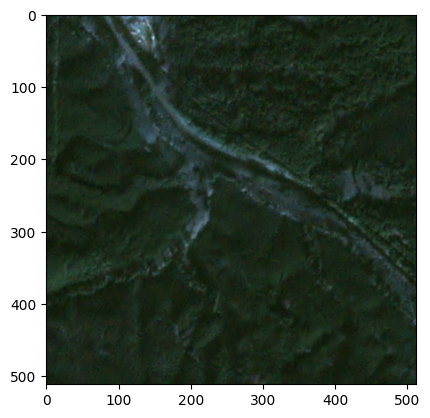

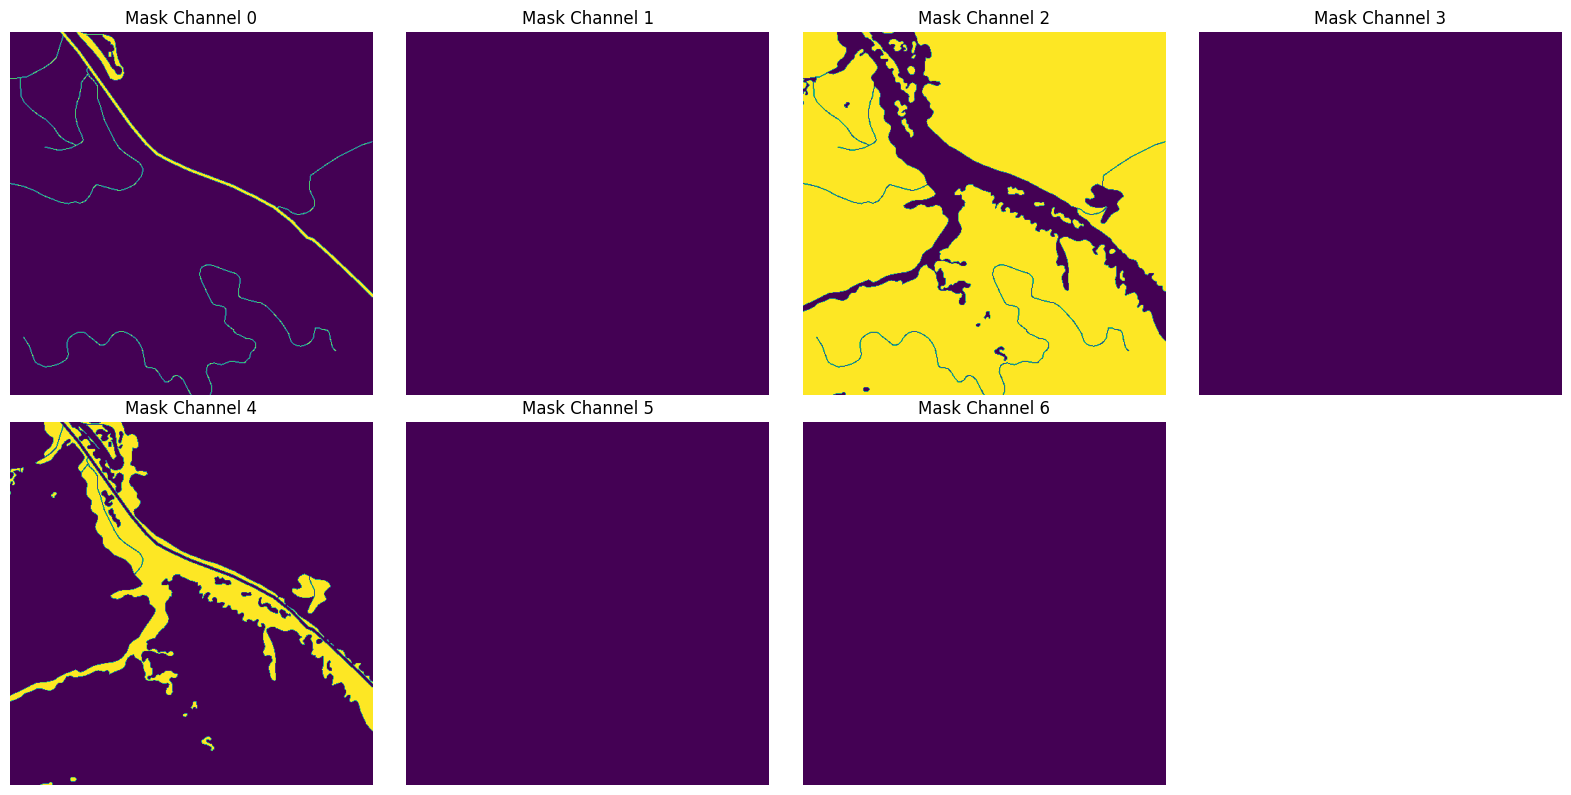

In [5]:
idx = 1
image, mask = evaldata[idx]

print(evaldata.get_id(idx), '\n')

# Check the shape of the image and mask
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

rgb_image = image[:3].permute(1, 2, 0).cpu().numpy()
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
plt.imshow(rgb_image)
plt.show()

# Number of channels in the mask
num_channels = mask.shape[0]

# Determine the grid size for displaying all channels (e.g., 2x4 grid for 7 channels)
rows = (num_channels + 3) // 4  # 4 images per row
cols = min(num_channels, 4)

# Create a figure with subplots
plt.figure(figsize=(16, rows * 4))  # Adjust figure size as needed

# Loop through each channel and plot
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Mask Channel {i}")
    plt.imshow(mask[i].cpu().numpy())  # Display channel as grayscale
    plt.axis('off')  # Optional: remove axis for cleaner visualization

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
for idx in range(10):
    print(evaldata.get_id(idx), '\n')

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif, crop (0, 0) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif, crop (0, 1) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif, crop (1, 0) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif, crop (1, 1) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-02-01.tif, crop (0, 0) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-02-01.tif, crop (0, 1) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-02-01.tif, crop (1, 0) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-02-01.tif, crop (1, 1) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-03-01.tif, crop (0, 0) 

/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/

In [7]:
num_crops_per_image = evaldata.num_crops_per_image

In [9]:
len(num_crops_per_image)

480

### Evaluation

In [ ]:
# Convert to predictions and targets
true_labels = labels.argmax(dim=1).cpu().numpy().flatten()
probs = F.softmax(outputs, dim=1)
pred_labels = probs.argmax(dim=1).cpu().numpy().flatten()

self.true_labels_all.extend(true_labels)
self.pred_labels_all.extend(pred_labels)

# Change detection logic
if self.scene_counter > 0:
    pred_bc = (self.pred_label_prev != pred_labels)
    true_bc = (self.true_label_prev != true_labels)
    self.pred_bc_all.extend(pred_bc)
    self.true_bc_all.extend(true_bc)

    pred_sc = pred_labels[true_bc]
    true_sc = true_labels[true_bc]
    self.pred_sc_all.extend(pred_sc)
    self.true_sc_all.extend(true_sc)

self.scene_counter += 1
if self.scene_counter == 24:  # Assuming 24 time series images per scene
    self.scene_counter = 0
    self.true_label_prev = None
    self.pred_label_prev = None
else:
    self.true_label_prev = true_labels
    self.pred_label_prev = pred_labels

return {"test_loss": self.loss_fn(outputs, labels)}

def test_epoch_end(self, outputs):
results_file = "test_results.txt"  # Output file for results

# Calculate test loss
avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
self.log("avg_test_loss", avg_test_loss)

# Calculate metrics
accuracy = accuracy_score(self.true_labels_all, self.pred_labels_all)
iou_score = jaccard_score(
    y_true=self.true_labels_all,
    y_pred=self.pred_labels_all,
    labels=range(self.num_classes),
    zero_division=0,
    average='weighted'
)
bc_score = jaccard_score(
    y_true=self.true_bc_all,
    y_pred=self.pred_bc_all,
    average='binary'
)
sc_score = jaccard_score(
    y_true=self.true_sc_all,
    y_pred=self.pred_sc_all,
    labels=range(self.num_classes),
    zero_division=0,
    average='weighted'
)
scs_score = (bc_score + sc_score) / 2

report = classification_report(
    self.true_labels_all,
    self.pred_labels_all,
    labels=range(self.num_classes),
    zero_division=0
)
cm = confusion_matrix(self.true_labels_all, self.pred_labels_all)

iou_scores_per_class = jaccard_score(
    self.true_labels_all,
    self.pred_labels_all,
    average=None,
    labels=range(self.num_classes)
)

# Prepare results string
results = []
results.append(f"Test Loss: {avg_test_loss:.4f}")
results.append(f"Accuracy: {accuracy:.4f}")
results.append(f"IoU (Jaccard Index): {iou_score:.4f}")
results.append(f"Binary Change (BC): {bc_score:.4f}")
results.append(f"Semantic Change (SC): {sc_score:.4f}")
results.append(f"Semantic Change Segmentation (SCS): {scs_score:.4f}")
results.append("\nClassification Report:\n" + report)
results.append("\nConfusion Matrix:\n" + str(cm))
for i, iou_score in enumerate(iou_scores_per_class):
    results.append(f"Class {i} IoU: {iou_score:.4f}")

# Write results to file
with open(results_file, "w") as f:
    f.write("\n".join(results))

# Optionally print to console as well
print("\n".join(results))

# Clear stored lists for next evaluation
self.true_labels_all.clear()
self.pred_labels_all.clear()
self.true_bc_all.clear()
self.pred_bc_all.clear()
self.true_sc_all.clear()
self.pred_sc_all.clear()

| **Model**               | **Parameters (M)** | **FLOPs (GFLOPs)** | **Strengths**                                        | **Weaknesses**                                        | **Use Cases**                                      | **Completed?** |
|--------------------------|---------------------|---------------------|-----------------------------------------------------|-----------------------------------------------------|---------------------------------------------------|---------------------------------------------------|
| **ResNet18**            | 11.7               | 1.8                 | Lightweight and fast, well-established architecture.| Limited representational capacity for very complex tasks.| Classification, lightweight segmentation, feature extraction. | Running |
| **ResNet50 (Baseline)** | 25.6               | 4.1                 | Strong baseline with good balance of efficiency and power.| Heavier than lightweight options like ResNet18.     | Classification, segmentation, transfer learning. | Completed |
| **DenseNet121**         | 7.98               | 2.9                 | Compact with efficient feature reuse (dense connections).| Slightly slower due to dense connections.           | Segmentation, object detection, transfer learning.| Running |
| **VGG11-BN**               | 133.4              | 7.8                 | Simple architecture, effective for transfer learning.| Very high parameters and FLOPs for its performance. | Transfer learning, general classification tasks.  | Running |
| **EfficientNet-B2** | 9.2                | 1.0                 | Balanced efficiency and accuracy, lightweight for onboard use. | Slightly heavier than B0 and B1.                    | Classification, segmentation on medium-complexity tasks. | Running
| **EfficientNet-B3** | 12                 | 1.8                 | More capacity and accuracy for moderately complex tasks.| Heavier than B2, requires more compute resources.    | Classification, segmentation for onboard systems with more compute power. | Running
| **MiT-B0**              | 3.4                | 0.52                | Lightweight transformer, ideal for dense predictions.| Transformer models may struggle on small datasets.  | Segmentation, dense predictions, low-resource scenarios. |
| **MiT-B1**              | 13.1               | 2.1                 | Moderate transformer with good efficiency and power.| Heavier than MiT-B0, still limited compared to CNNs.| Segmentation, complex dense predictions.          |
| **MiT-B2**              | 24.2               | 4.2                 | Balanced size and power, strong for segmentation tasks.| Heavier than MiT-B1, requires more compute.         | Segmentation, dense predictions for medium-complexity tasks. |
| **MiT-B3**              | 43.4               | 8.1                 | High capacity, strong segmentation performance.     | Larger size, higher compute requirements.           | Complex segmentation and dense predictions.       |

In [53]:
['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d', 'timm-mobilenetv3_large_075', 'timm-mobilenetv3_large_100', 'timm-mobilenetv3_large_minimal_100', 'timm-mobilenetv3_small_075', 'timm-mobilenetv3_small_100', 'timm-mobilenetv3_small_minimal_100', 'timm-gernet_s', 'timm-gernet_m', 'timm-gernet_l', 'mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5', 'mobileone_s0', 'mobileone_s1', 'mobileone_s2', 'mobileone_s3', 'mobileone_s4']

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'resnext50_32x4d',
 'resnext101_32x4d',
 'resnext101_32x8d',
 'resnext101_32x16d',
 'resnext101_32x32d',
 'resnext101_32x48d',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'inceptionresnetv2',
 'inceptionv4',
 'efficientnet-b0',
 'efficientnet-b1',
 'efficientnet-b2',
 'efficientnet-b3',
 'efficientnet-b4',
 'efficientnet-b5',
 'efficientnet-b6',
 'efficientnet-b7',
 'mobilenet_v2',
 'xception',
 'timm-efficientnet-b0',
 'timm-efficientnet-b1',
 'timm-efficientnet-b2',
 'timm-efficientnet-b3',
 'timm-efficientnet-b4',
 'timm-efficientnet-b5',
 'timm-efficientnet-b6',
 'timm-efficientnet-b7',
 'timm-efficientnet-b8',
 'timm-efficientnet-l2'